 ![FREYA Logo](https://github.com/datacite/pidgraph-notebooks-python/blob/master/images/freya_200x121.png?raw=true) | [FREYA](https://www.project-freya.eu/en) WP2 [User Story 10](https://github.com/datacite/freya/issues/45) | As a funder, we want to be able to find all the outputs related to our awarded grants, including block grants such as doctoral training grants, for management info and looking at impact. 
 :------------- | :------------- | :-------------

Funders are interested in monitoring the output of grants they award - while the grant is active as well as retrospectively. The quality, quantity and types of the grant's outputs are useful proxies for the value obtained as a result of the funder's investment.<p />
This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to retrieve all outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) from [European Union](https://doi.org/10.13039/501100000780) to date. 

**Goal**: By the end of this notebook you should be able to:
- Retrieve all outputs of a grant award from a specific funder; 
- Plot number of outputs per year-quarter of the grant award duration;
- Display de-duplicated outputs in tabular format, including the number of their citations, views and downloads;
- Plot a pie chart of the number of outputs per resource type;
- Display an interactive chord plot of co-authorship relationships across all outputs, e.g. <br> <img src="example_plot.png" width="318" height="309" />
- Plot a pie chart of the number of outputs per license type;
- Plot an interactive stacked bar plot showing the proportion of outputs of each type issued under a given license type.

## Install libraries and prepare GraphQL client

In [1]:
%%capture
# Install required Python packages
#!pip install gql requests chord==0.0.17 numpy

In [2]:
# Prepare the GraphQL client
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

## Define and run GraphQL query
Define the GraphQL query to find all outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) from [European Union](https://doi.org/10.13039/501100000780) to date.

In [3]:
# Generate the GraphQL query: find all outputs of FREYA grant award (https://cordis.europa.eu/project/id/777523) from funder (EU) to date
#query_params = {
#    "funderId" : "https://doi.org/10.13039/501100000780",
#    "funderAwardQuery" : "fundingReferences.awardNumber:777523",
#    "maxWorks" : 200
#}


# a different grant award to the above default (which works) - Agricultural Insurance based on EO data
query_params = {
    "funderId" : "https://doi.org/10.13039/501100000780",
    "funderAwardQuery" : "fundingReferences.awardNumber:821964",
    "maxWorks" : 200
}

# a different grant award which does not seem to work
#query_params = {
#    "funderId" : "https://doi.org/10.13039/501100000780",
#    "funderAwardQuery" : "fundingReferences.awardNumber:773701",
#    "maxWorks" : 200
#}

query = gql("""query getGrantOutputsForFunderAndAward($funderId: ID!, $funderAwardQuery: String!, $maxWorks: Int!)
{
funder(id: $funderId) {
  name
  works(query: $funderAwardQuery, first: $maxWorks) {
      totalCount
      nodes {
        id
        formattedCitation(style: "vancouver")
        titles {
          title
        }
        descriptions {
          description
        }        
        types {
          resourceType
        }
        dates {
          date
          dateType
        }
        versionOfCount
        rights {
          rights
          rightsIdentifier
          rightsUri
        }        
        creators {
          id
          name
        }
        fundingReferences {
          funderIdentifier
          funderName
          awardNumber
          awardTitle
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

Run the above query via the GraphQL client

In [4]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

In [5]:
data

{'funder': {'name': 'European Commission',
  'works': {'totalCount': 28,
   'nodes': [{'id': 'https://doi.org/10.5281/zenodo.3339139',
     'formattedCitation': 'Petalios D, Budimir M, Radišić M. D7.1: Dissemination, Exploitation and Communication (DEC) Plan. 2019May2; Available from: https://zenodo.org/record/3339139',
     'titles': [{'title': 'D7.1: Dissemination, Exploitation and Communication (DEC) Plan'}],
     'descriptions': [{'description': 'The BEACON project aims to develop and commercialize a toolbox of services, to enable agricultural insurance companies to overcome challenges in three main procedures – underwriting; damage assessment; and contract monitoring, when developing Agricultural Insurance (AgI) services. BEACON is taking advantage of innovations in Earth Observation (EO), weather intelligence and ICT / blockchain technology to deliver tangible innovation in the form of tools and services for the insurance companies enabling them to exploit the untapped market pot

## Display total number of works 
Display the total number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs to date.

In [6]:
# Get the total number of outputs to date
funder = data['funder']['works']
display(Markdown(str(funder['totalCount'])))

28

## Plot number of works per quarter
Display a bar plot of number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs to date, per each quarter of project's duration.

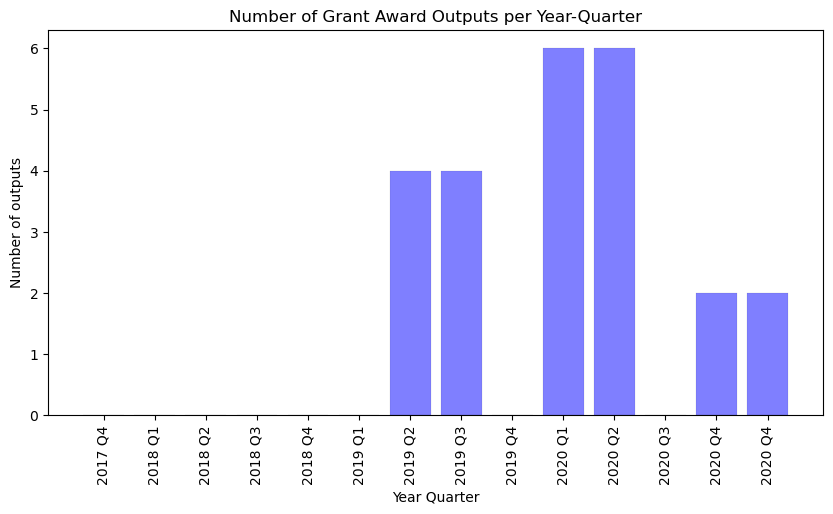

In [7]:
# Plot the number of FREYA outputs to date, by year
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# Return quarter (number) given month (number)
def get_quarter(month):
    return (month - 1) // 3 + 1

# Return list of consecutive years between min_year_quarter and max_year_quarter inclusive
def get_consecutive_year_quarters(min_year_quarter, max_year_quarter):
    year_quarters = ["%d Q%d" % (min_year_quarter[0],min_year_quarter[1])]
    yq = min_year_quarter
    while yq != max_year_quarter:
        year = yq[0]
        quarter = yq[1]
        if quarter == 4:
            year += 1
            quarter = 1
        else:
            quarter += 1
        yq = (year, quarter)
        year_quarters.append("%d Q%d" % (year,quarter))
    year_quarters.append("%d Q%d" % (max_year_quarter[0],max_year_quarter[1])) 
    return year_quarters

plt.rcdefaults()

# Retrieve works counts by year-quarter from nodes
# Pick out date of type: 'Issued'; failing that use 'Created' date.
num_outputs_dict = {}
funder = data['funder']['works']
for r in funder['nodes']:
    node_date = None
    for date_dict in r['dates']:
        ym = date_dict['date'].split('-')[0:2]
        if len(ym) < 2:
            continue
        yq = ym[0] + " Q" + str(get_quarter(int(ym[1])))
        if node_date is None:
            if date_dict['dateType'] in ['Issued', 'Created']:
                node_date = yq
        else:
            if date_dict['dateType'] in ['Issued']:
                node_date = yq
    if node_date:
        if node_date not in num_outputs_dict:
            num_outputs_dict[node_date] = 0
        num_outputs_dict[node_date] += 1;
    
# Sort works counts by year-quarter in chronological order
sorted_year_quarters = sorted(list(num_outputs_dict.keys()))
# Get all consecutive year-quarters FREYA-specific start-end year-quarter
year_quarters = get_consecutive_year_quarters((2017,4), (2020,4))       
# Populate non-zero counts for year_quarters                          
num_outputs = []
for yq in year_quarters:
    if yq in sorted_year_quarters:
        num_outputs.append(num_outputs_dict[yq])
    else:
        num_outputs.append(0)
        
# Generate a plot of number of grant outputs by year - quarter
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
x_pos = np.arange(len(year_quarters))
ax.bar(x_pos, num_outputs, align='center', color='blue', edgecolor='black', linewidth = 0.1, alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(year_quarters, rotation='vertical')
ax.set_ylabel('Number of outputs')
ax.set_xlabel('Year Quarter')
ax.set_title('Number of Grant Award Outputs per Year-Quarter')
plt.show()


## Display de-duplicated works in tabular format
Display the outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) in a html table, including the number of their citations, views and downloads. Note that the outputs are de-duplicated, i.e. outputs that are versions of another output are excluded.

In [8]:
from IPython.core.display import display, HTML
import textwrap
xstr = lambda s: 'General' if s is None else str(s)

# Get details for each output
outputs = [['ID','Type','Publication Date','Formatted Citation','Descriptions', 'Number of Citations', 'Number of Views', 'Number of Downloads']]
# Since there is scope for duplicates in Zenodo, versions of previously seen nodes are considered duplicates and stored in duplicate_versions so that 
# they can be excluded if seen later
for r in funder['nodes']:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    if r['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue
    # As Publication Date, pick out date of type: 'Issued'; failing that use 'Created' date.
    pub_date = None
    for date_dict in r['dates']:
        if pub_date is None:
            if date_dict['dateType'] in ['Issued', 'Created']:
                pub_date = date_dict['date'];
        else:
            if date_dict['dateType'] in ['Issued']:
                pub_date = date_dict['date'];
    
    titles = '; '.join([s['title'] for s in r['titles']])
    creators = '; '.join(['<a href="%s">%s</a>' % (s['id'],s['name']) for s in r['creators']])
    formatted_citation = "%s. %s. %s; Available from: %s" % (creators, titles, pub_date, id) 
    resource_type = xstr(r['types']['resourceType'])
    descriptions = textwrap.shorten('; '.join([s['description'] for s in r['descriptions']]), width=200, placeholder="...")
    output = [id, resource_type, pub_date, formatted_citation, descriptions, str(r['citationCount']), str(r['viewCount']), str(r['downloadCount'])]
    outputs += [output]
    
# Display outputs as html table 
html_table = '<html><table>'   
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,Type,Publication Date,Formatted Citation,Descriptions,Number of Citations,Number of Views,Number of Downloads
10.5281/zenodo.3339139,Project deliverable,2019-05-02,"Petalios, Dimitrios; Budimir, Maja; Radišić, Mladen. D7.1: Dissemination, Exploitation and Communication (DEC) Plan. 2019-05-02; Available from: 10.5281/zenodo.3339139","The BEACON project aims to develop and commercialize a toolbox of services, to enable agricultural insurance companies to overcome challenges in three main procedures – underwriting; damage...",0,0,0
10.5281/zenodo.3339150,Project deliverable,2019-05-31,"Petalios, Dimitrios. D7.4: Agricultural Insurance Enablers – Advisory Board report. 2019-05-31; Available from: 10.5281/zenodo.3339150","The current Deliverable 7.4: “Agricultural Insurance Enablers” Advisory Board report, provides an overview of the establishment of the BEACON Advisory Board (AB) and presents the most important...",0,0,0
10.5281/zenodo.3339149,Project deliverable,2019-05-31,"Petalios, Dimitrios. D7.4: Agricultural Insurance Enablers – Advisory Board report. 2019-05-31; Available from: 10.5281/zenodo.3339149","The current Deliverable 7.4: “Agricultural Insurance Enablers” Advisory Board report, provides an overview of the establishment of the BEACON Advisory Board (AB) and presents the most important...",0,0,0
10.5281/zenodo.3465497,Project deliverable,2019-09-30,"Asteriou, Stergios; Karavias, George; Voutsinos, George; Sylignakis, Stylianos. D1.6: Risk Management Plan. 2019-09-30; Available from: 10.5281/zenodo.3465497","The aim of this deliverable is to provide to the partners a useful tool for managing and reducing the risks, identified before and during the project, to document risk mitigation strategies being...",0,0,0
10.5281/zenodo.3465496,Project deliverable,2019-09-30,"Asteriou, Stergios; Karavias, George; Voutsinos, George; Sylignakis, Stylianos. D1.6: Risk Management Plan. 2019-09-30; Available from: 10.5281/zenodo.3465496","The aim of this deliverable is to provide to the partners a useful tool for managing and reducing the risks, identified before and during the project, to document risk mitigation strategies being...",0,0,0
10.5281/zenodo.3611345,Project deliverable,2019-07-30,"Karavias, George; Karakonstantinos, Christos; Voutsinos, George. D1.3 Data Management Plan. 2019-07-30; Available from: 10.5281/zenodo.3611345",The purpose of the current deliverable is to present the 1st Data Management Plan (DMP) of the BEACON project. This deliverable has been compiled with the collaborative work among the coordinator...,0,0,0
10.5281/zenodo.3611344,Project deliverable,2019-07-30,"Karavias, George; Karakonstantinos, Christos; Voutsinos, George. D1.3 Data Management Plan. 2019-07-30; Available from: 10.5281/zenodo.3611344",The purpose of the current deliverable is to present the 1st Data Management Plan (DMP) of the BEACON project. This deliverable has been compiled with the collaborative work among the coordinator...,0,0,0
10.5281/zenodo.3634426,Other,2020-01-03,"Jiménez-Donaire, María Del Pilar; Tarquis, Ana; Uan Vicente Giráldez. Evaluation of a combined drought indicator and its potential for agricultural drought prediction in southern Spain. 2020-01-03; Available from: 10.5281/zenodo.3634426","Drought prediction is crucial, especially where the rainfall regime is irregular, such as in Mediterranean countries. A new combined drought indicator (CDI) integrating rainfall, soil moisture and...",0,0,0
10.5281/zenodo.3676491,Conference paper,2020-02-20,"Lekakis, Emanuel; Kotsopoulos, Stylianos; Mygdakos, Gregory; Agathoklis Dimitrakos; Ifigeneia-Maria Tsioutsia; Polimachi Simeonidou. Redefining Agricultural Insurance services using Earth Observation data. The case of Beacon project.. 2020-02-20; Available from: 10.5281/zenodo.3676491",BEACON is a market-led project that couples cutting edge Earth Ob-servation (EO) technology with weather intelligence and blockchain to deliver a toolbox for the Agricultural Insurance (AgI) s

## Plot number of outputs per resource type
Plot as a pie chart the number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs per resource type.

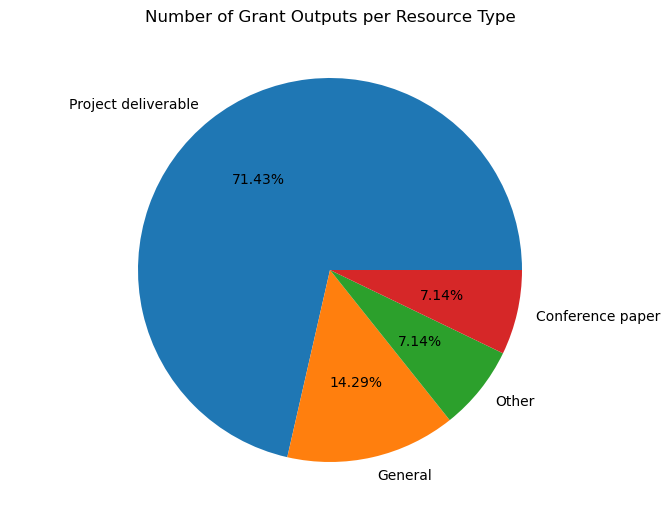

In [9]:
# Plot as a pie chart the number of outputs per resource type
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import operator

xstr = lambda s: 'General' if s is None else str(s)

plt.rcdefaults()

# Retrieve works counts by resource type from nodes
# Pick out date of type: 'Issued'; failing that use 'Created' date.
funder = data['funder']['works']
num_outputs_dict = {}
for r in funder['nodes']:
    resource_type = xstr(r['types']['resourceType'])
    if resource_type not in num_outputs_dict:
        num_outputs_dict[resource_type] = 0
    num_outputs_dict[resource_type] += 1;
    
# Sort resource types by count of work desc
sorted_num_outputs = sorted(num_outputs_dict.items(),key=operator.itemgetter(1),reverse=True)
# Populate lists needed for pie chart
resource_types = [s[0] for s in sorted_num_outputs] 
num_outputs = [s[1] for s in sorted_num_outputs] 

# Generate a pie chart of number of grant outputs by resource type
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of Grant Outputs per Resource Type')
ax.axis('equal')
ax.pie(num_outputs, labels = resource_types,autopct='%1.2f%%')
plt.show()

## Display an interactive plot of co-authorship relationships across all outputs
Display an interactive chord plot representing co-authorship relationships across all [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs.

In [10]:
# Generate a Chord plot representing co-authorship relationships across all grant award outputs
from chord import Chord       
from IPython.display import IFrame

all_creator_names_by_node = []
all_creator_names_set = set([])
funder = data['funder']['works']
for r in funder['nodes']:
    if r['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue
    # To minimise cropping of names in the below, retain just the first letter of the first name
    # if the author name is well formatted     
    creator_names = []
    for name in [s['name'] for s in r['creators'] if s['name']]:
        if name.find(",") > 0:
            creator_names.append(name[0:name.index(",") + 3])
        elif name.find(",") == 0:
            creator_names.append(name[1:].strip())
        else:
            creator_names.append(name)
    all_creator_names_by_node.append(creator_names)
    all_creator_names_set.update(creator_names)
    
# Assemble data structures for the co-authorship chord diagram
all_creator_names = sorted(list(all_creator_names_set))

# Initialise chord data matrix
length = len(all_creator_names)
coauthorship_matrix = []
for i in range(length):
    r = []
    for j in range(length):
        r.append(0)
    coauthorship_matrix.append(r)
    
# Populate chord data matrix
for node_creators in all_creator_names_by_node:
    for creator in node_creators:
        c_pos = all_creator_names.index(creator)
        for co_creator in node_creators:
            co_pos = all_creator_names.index(co_creator)
            if c_pos != co_pos:
                coauthorship_matrix[c_pos][co_pos] += 1

# display co-authorship cord diagram
plot = Chord(coauthorship_matrix, all_creator_names, padding=0.04, wrap_labels=False, margin=130, width=1000).to_html()
IFrame(src="./out.html", width=1000, height=1000)

ModuleNotFoundError: No module named 'chord'

## Plot number of outputs per license type
Plot as a pie chart the number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs per license type.

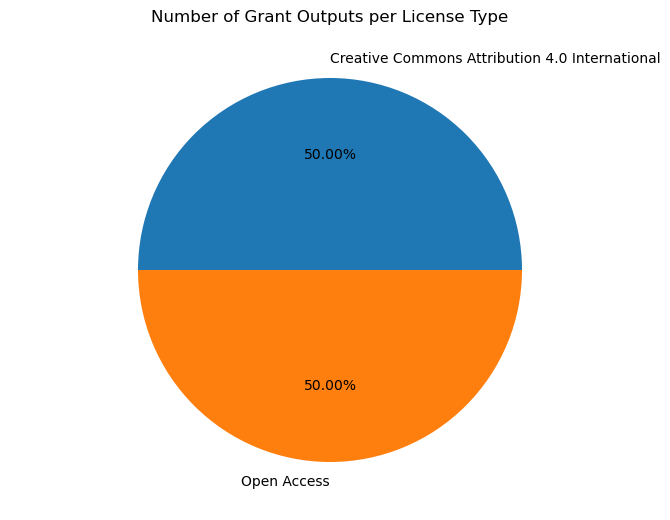

In [11]:
# Plot as a pie chart the number of outputs per license type
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import operator

xstr = lambda s: 'General' if s is None else str(s)
xstr1 = lambda s: 'Not available' if s is None else str(s)

plt.rcdefaults()

# Retrieve works counts by resource type from nodes
funder = data['funder']
awardTitle = None

right2NumOutputs = {}
resourceType2NumOutputs = {}

for r in funder['works']['nodes']:
    resourceType = xstr(r['types']['resourceType'])
    if r['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue
    if not awardTitle:
        awardTitle = r['fundingReferences'][0]['awardTitle'] 
    if resourceType not in resourceType2NumOutputs:
        resourceType2NumOutputs[resourceType] = 0
    resourceType2NumOutputs[resourceType] += 1
    if not r['rights']:
        r['rights'].append({'rights': 'Not available'})
    for rights in r['rights']:
        right = xstr1(rights['rights'])
        if right not in right2NumOutputs:
            right2NumOutputs[right] = 0
        right2NumOutputs[right] += 1;
    
# Sort resource types by count of work desc
sorted_num_outputs = sorted(right2NumOutputs.items(),key=operator.itemgetter(1),reverse=True)
# Populate lists needed for pie chart
resource_types = [s[0] for s in sorted_num_outputs] 
num_outputs = [s[1] for s in sorted_num_outputs] 

# Generate a pie chart of number of grant outputs by resource type
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of Grant Outputs per License Type')
ax.axis('equal')
ax.pie(num_outputs, labels = resource_types,autopct='%1.2f%%')
plt.show()

## Plot license type counts per resources type
Plot stacked bar plot showing how <ins>each type</ins> of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs contributes their license type counts to the corresponding aggregated total.


In [12]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd
from operator import itemgetter

xstr = lambda s: 'General' if s is None else str(s)
xstr1 = lambda s: 'Not available' if s is None else str(s)

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
def px_stacked_bar(df, color_name='License Type', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)
 
# Collect metric counts
funder = data['funder']
funderName = funder['name']

# Initialise dicts for the stacked bar plot
labels = {0: 'All Output Types'}

# Map each license type to a dict in turn mapping the position of the output's bar in plot 
# to the count of outputs corresponding to that license type
licenseType2Pos2Count = {}

# Collect output type labels and assign bar positions in plot
outputType2Pos = {}
pos = 1
for outputType, num in sorted(resourceType2NumOutputs.items(), key = itemgetter(1), reverse = True):
    labels[pos] = outputType
    outputType2Pos[outputType] = pos
    pos += 1
    
# Populate license type counts per output type (key = i) and add them to the aggregated counts (key: 0)
for node in funder['works']['nodes']:
    if node['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue       
    resource_type = xstr(node['types']['resourceType'])
    pos = outputType2Pos[resource_type]
    if len(node['rights']) == 0:
        node['rights'].append({'rights': 'Not available'})
    for rights in node['rights']:
        right = xstr1(rights['rights'])
        if right not in licenseType2Pos2Count:
            licenseType2Pos2Count[right] = {}
            for pos1, _ in enumerate(labels):
                # Initialise right's counts for each output type
                licenseType2Pos2Count[right][pos1] = 0
        licenseType2Pos2Count[right][0] += 1 
        licenseType2Pos2Count[right][pos] += 1
        
# Create stacked bar plot
x_name = "Output Types (sorted by number of outputs)"
dfDict = {x_name: labels}

for right in licenseType2Pos2Count:
    dfDict[right] = licenseType2Pos2Count[right]

df = pd.DataFrame(dfDict)
fig = px_stacked_bar(df.set_index(x_name), y_name = "Output Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='out1.html')

# Display plot from the saved html file
display(Markdown("License Types of %s's [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs, shown per output type as a stacked bar plot:" % funderName))
IFrame(src="./out1.html", width=500, height=500)

License Types of European Commission's [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs, shown per output type as a stacked bar plot: